In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [14]:
df = pd.read_csv('../data/2-processed/processed.csv')
df.dropna(inplace=True)
display(df)
display(df.columns)

,views,sentiment_score,close,volume,return,rolling_mean_7,rolling_mean_14,rolling_std_7,rolling_std_14,day,month,year
13,94414,0.220994,255.19,6029760.0,0.019711,0.001496,0.003449,0.017456,0.014636,2,7,2014
14,176951,0.571429,257.70,5029670.0,0.009740,-0.000166,0.002182,0.015715,0.013081,3,7,2014
15,194270,0.102740,253.90,5432990.0,-0.014967,0.002159,0.000087,0.010782,0.013326,4,7,2014
16,241041,1.444687,248.99,6265420.0,-0.019720,-0.000223,-0.000836,0.013597,0.014255,7,7,2014
17,135575,0.039216,249.99,7000330.0,0.004000,0.000206,-0.000345,0.013689,0.014298,8,7,2014
...,...,...,...,...,...,...,...,...,...,...,...,...
2890,306503,0.944193,409.65,3688415.0,0.018064,0.003261,-0.000189,0.018008,0.014195,15,12,2025
2891,70523,0.432692,413.00,3507863.0,0.008111,0.000935,0.000881,0.015732,0.014217,16,12,2025
2892,129196,0.244898,411.45,2995120.0,-0.003767,0.002879,0.001806,0.013818,0.013380,17,12,2025
2893,152050,0.094340,409.25,5504714.0,-0.005376,0.000343,0.000664,0.013407,0.013252,18,12,2025


Index(['views', 'sentiment_score', 'close', 'volume', 'return',
       'rolling_mean_7', 'rolling_mean_14', 'rolling_std_7', 'rolling_std_14',
       'day', 'month', 'year'],
      dtype='object')

Проверим признаки через feature importance

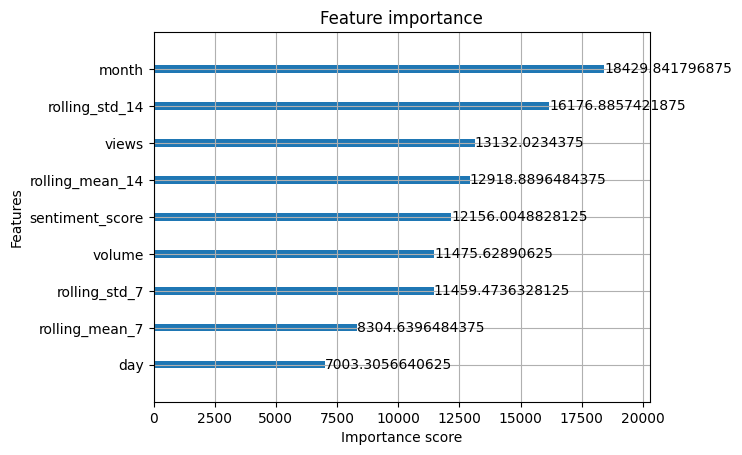

In [17]:
from xgboost import XGBRegressor, plot_importance
from sklearn.preprocessing import MinMaxScaler

features = [
        'views', 'sentiment_score', 'volume',
       'rolling_mean_7', 'rolling_mean_14', 'rolling_std_7', 'rolling_std_14',
       'day', 'month'
]

merged = pd.read_csv('../data/2-processed/processed.csv')

X = merged[features]
y = merged['close']

scaler = MinMaxScaler()
scaler.fit(X, y)
X_sc = scaler.transform(X)

model = XGBRegressor()
model.fit(X, y)

plot_importance(model, importance_type='gain', max_num_features=10)
plt.plot()
importance_scores = model.get_booster().get_score(importance_type='gain')

Проверим часть параметров, связанных с новостями

<Axes: >

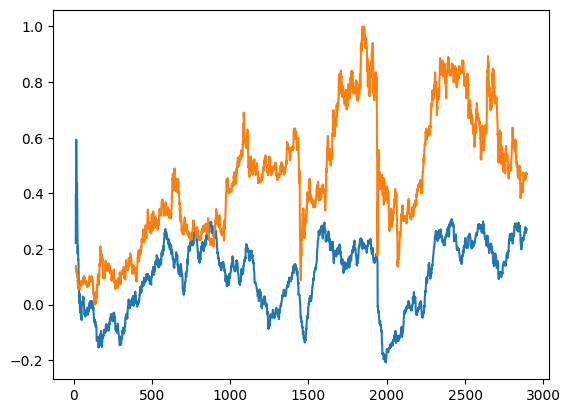

In [24]:
df['sentiment_score'].ewm(alpha=0.02).mean().plot()
((df['close'] - df['close'].min()) / (df['close'].max() - df['close'].min())).plot()

<Axes: >

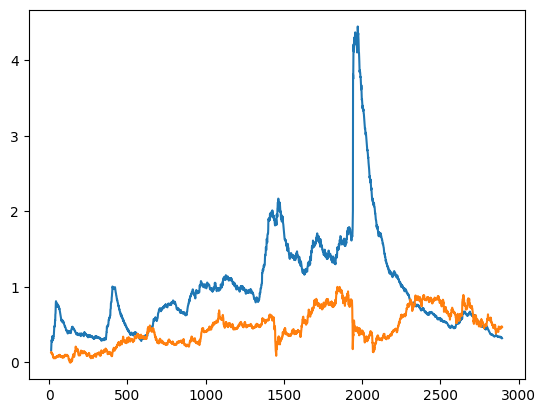

In [ ]:
(df['views'].ewm(alpha=0.02).mean() / df['views'].mean()).plot() 
((df['close'] - df['close'].min()) / (df['close'].max() - df['close'].min())).plot()

Заметим, что большие просмотры кореллируют с скачками цен на акции, значит можно попытаться сделать признак, который будет смотреть есть ли скачок в просмотрах и сравнивать с фоновым сентиментом. Добавим признак аномального флияния, который будет за этим следить

In [ ]:
df['views_mod'] = (df['views'].ewm(alpha=0.02).mean() / df['views'].mean()).apply(lambda x: x / (1 + np.abs(x)))
df['sentiment_score_mod'] = df['sentiment_score'].ewm(alpha=0.02).mean()

<Axes: >

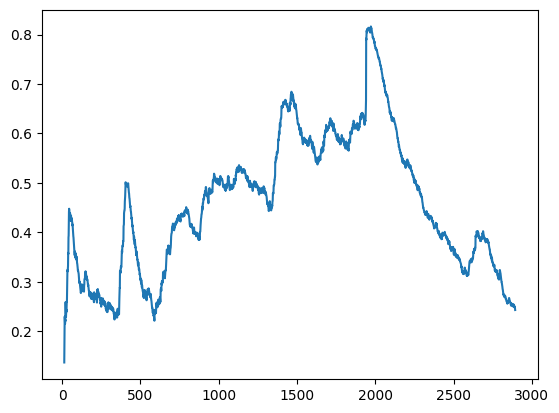

In [47]:
df['views_mod'].plot()

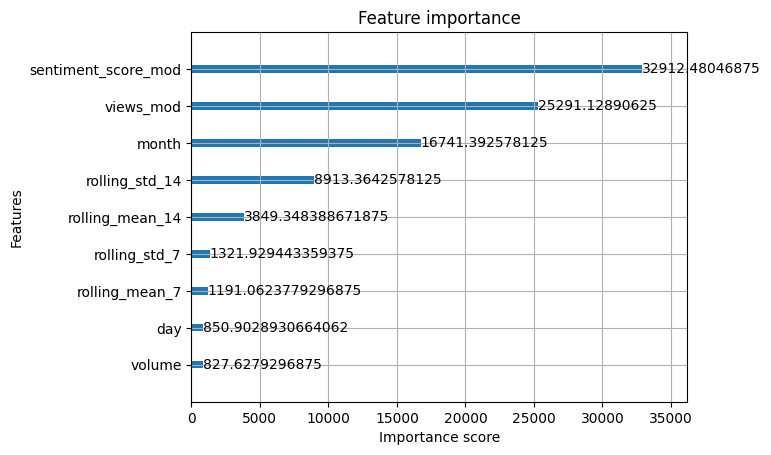

In [49]:
features = [
        'views_mod', 'sentiment_score_mod', 'volume',
       'rolling_mean_7', 'rolling_mean_14', 'rolling_std_7', 'rolling_std_14',
       'day', 'month'
]

X = df[features]
y = df['close']

scaler = MinMaxScaler()
scaler.fit(X, y)
X_sc = scaler.transform(X)

model = XGBRegressor()
model.fit(X, y)

plot_importance(model, importance_type='gain', max_num_features=10)
plt.plot()
importance_scores = model.get_booster().get_score(importance_type='gain')

Не используем признаки rolling_std_7, rolling_mean_7, day, volume, как наименее влиятельные. Также надо не забывать, что изза того, что ewm сглаживание может переобучать модель (брать информацию из test, то стоит сглаживать отдельно как и views)